# Imports The Required Libraries

In [40]:
import pandas as pd
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.cm as cm
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from minisom import MiniSom
from sklearn.metrics import silhouette_samples

# Load GRIB File & Convert It To CSV File

In [3]:
# Load the GRIB file and filter by edition
file_path = "data.grib"
ds = xr.open_dataset(
    file_path,
    engine="cfgrib",
    backend_kwargs={
        "filter_by_keys": {"edition": 1}
    }
)

# Convert to DataFrame
df = ds.to_dataframe().reset_index()

# Save to CSV
csv_file = "extracted_data.csv"
df.to_csv(csv_file, index=False)

skipping variable: paramId==139 shortName='stl1'
Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\cfgrib\dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\cfgrib\dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1725148800, 1725235200, 1725321600, 1725408000, 1725494400,
       1725580800, 1725667200, 1725753600, 1725840000, 1725926400,
       1726012800, 1726099200, 1726185600, 1726272000, 1726358400,
       1726444800, 1726531200, 1726617600, 1726704000, 1726790400])) new_value=Variable(dimensions=('time',), data=array([1725192000, 1725195600, 1725199200, 1725202800, 1725206400,
       1725210000, 1725213600, 1725217200, 1725220800, 1725224400,
       172

Data saved to extracted_data.csv


# Load Dataset

In [3]:
data = pd.read_csv('extracted_data.csv')
data.head()

,time,step,latitude,longitude,number,surface,valid_time,t2m,sro,tp
0,2024-09-01,0 days 12:00:00,36.772,50.435000,0,0.0,2024-09-01 12:00:00,293.65430,0.000005,0.000053
1,2024-09-01,0 days 12:00:00,36.772,50.535028,0,0.0,2024-09-01 12:00:00,293.83447,0.000008,0.000095
2,2024-09-01,0 days 12:00:00,36.772,50.635056,0,0.0,2024-09-01 12:00:00,295.16553,0.000007,0.000097
3,2024-09-01,0 days 12:00:00,36.772,50.735083,0,0.0,2024-09-01 12:00:00,296.66700,0.000005,0.000106
4,2024-09-01,0 days 12:00:00,36.772,50.835111,0,0.0,2024-09-01 12:00:00,297.82860,0.000003,0.000107


In [4]:
data.shape

(35520, 10)

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,35520.0,36.621750,0.112141,36.47100,3.654675e+01,36.622000,36.697000,36.772000
longitude,35520.0,52.235500,1.068019,50.43500,5.133525e+01,52.235500,53.135750,54.036000
number,35520.0,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000
surface,35520.0,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000
t2m,35520.0,294.687889,4.891162,278.92407,2.916143e+02,295.225095,298.158940,307.494140
sro,35520.0,0.000101,0.000310,0.00000,2.793968e-08,0.000002,0.000030,0.003882
tp,35520.0,0.001676,0.002794,0.00000,2.754273e-05,0.000383,0.002105,0.026095


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35520 entries, 0 to 35519
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        35520 non-null  object 
 1   step        35520 non-null  object 
 2   latitude    35520 non-null  float64
 3   longitude   35520 non-null  float64
 4   number      35520 non-null  int64  
 5   surface     35520 non-null  float64
 6   valid_time  35520 non-null  object 
 7   t2m         35520 non-null  float64
 8   sro         35520 non-null  float64
 9   tp          35520 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 2.7+ MB


# EDA & Data Preprocessing

time          0
step          0
latitude      0
longitude     0
number        0
surface       0
valid_time    0
t2m           0
sro           0
tp            0
dtype: int64

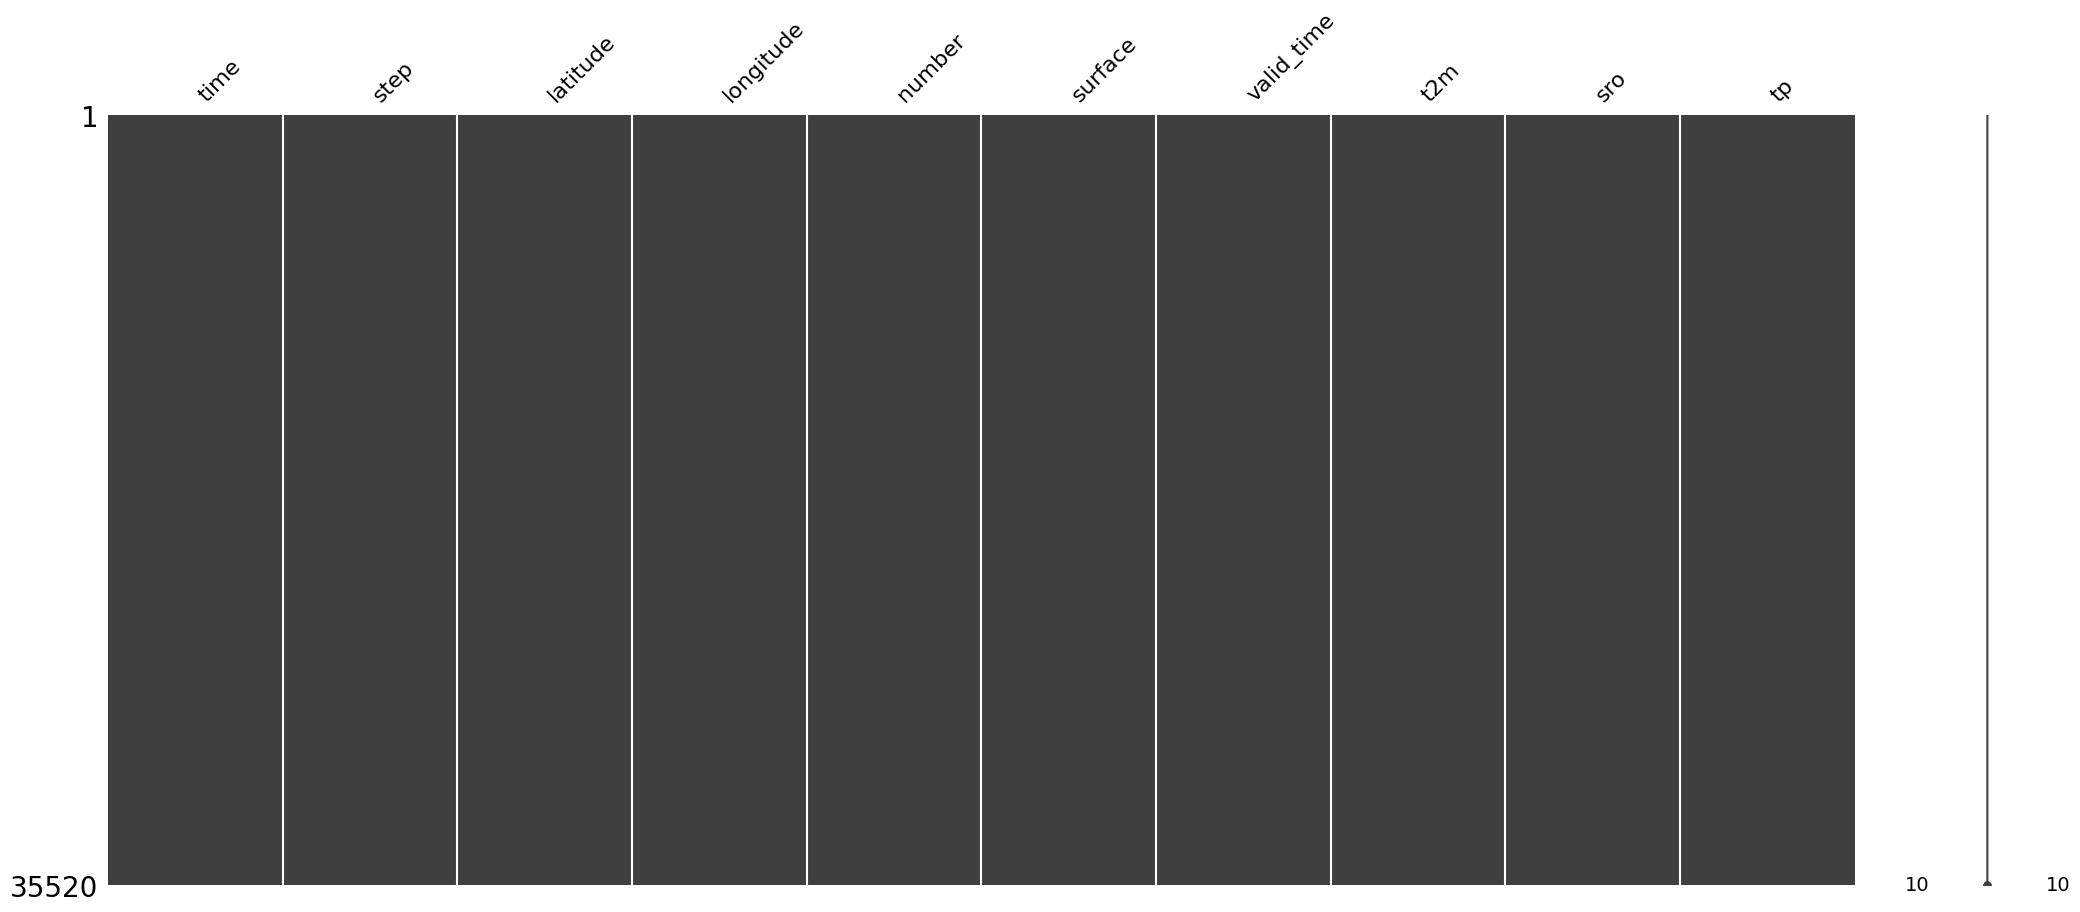

In [7]:
# Visualize missing data in the dataset using a matrix plot
msno.matrix(data) 
# Check for missing values
data.isnull().sum()

In [8]:
# Select relevant features
features = data[['tp', 't2m']]

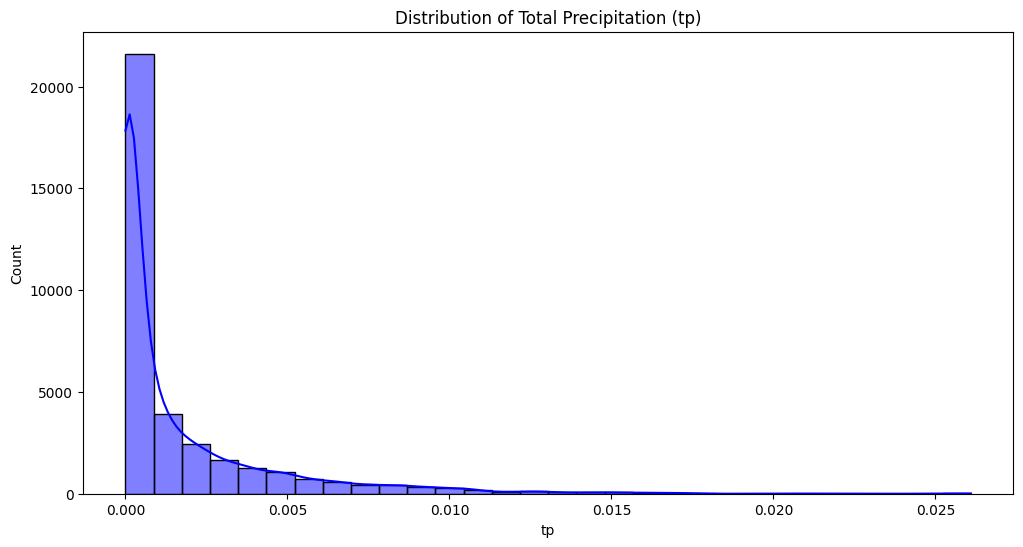

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(features['tp'], kde=True, bins=30, color='blue')
plt.title('Distribution of Total Precipitation (tp)')
plt.show()


Text(0.5, 1.0, 'Distribution of Temperature (t2m)')

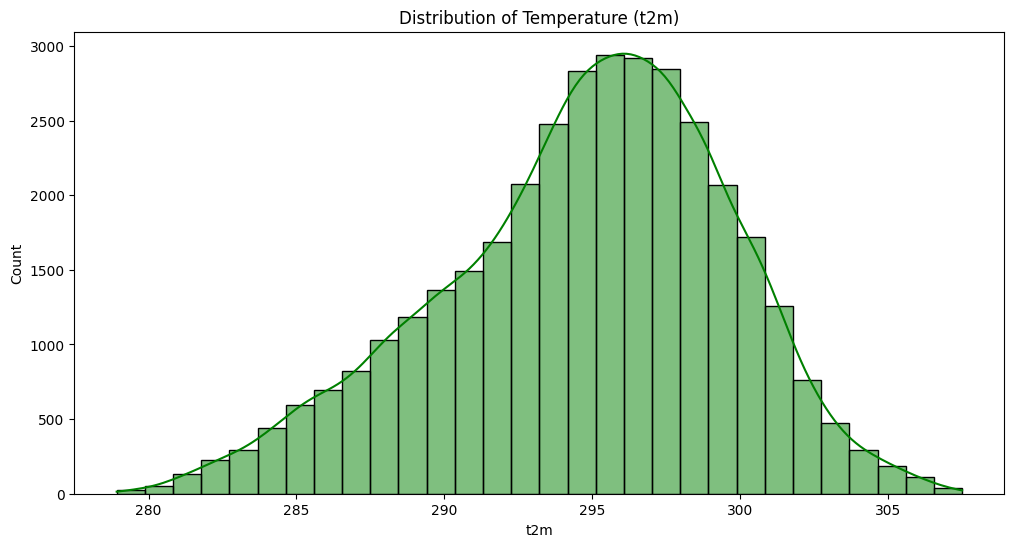

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(features['t2m'], kde=True, bins=30, color='green')
plt.title('Distribution of Temperature (t2m)')

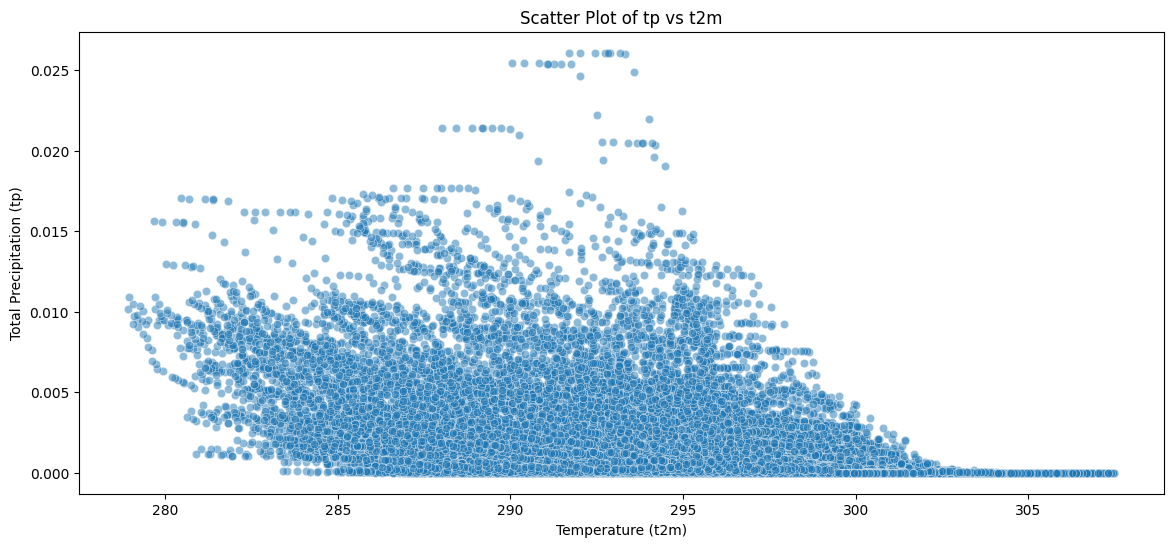

In [16]:
plt.figure(figsize=(14, 6))
sns.scatterplot(x='t2m', y='tp', data=features, alpha=0.5)
plt.title('Scatter Plot of tp vs t2m')
plt.xlabel('Temperature (t2m)')
plt.ylabel('Total Precipitation (tp)')
plt.show()


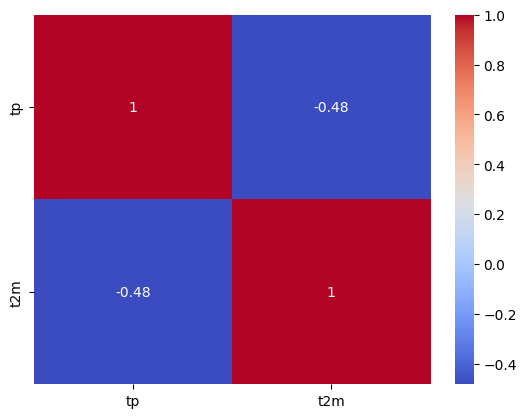

In [13]:
sns.heatmap(features.corr(), annot=True, cmap= "coolwarm")
plt.show()

# Feature Engineering & Applying PCA

In [18]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = PCA(n_components=2)  # Reduce to 2 components
pca_features = pca.fit_transform(scaled_features)
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance by PCA: {explained_variance:.2f}")

Explained Variance by PCA: 1.00


# Clustering

### Funtions For Enhance The Clustring Methods

In [26]:
# Function to calculate WCSS for Agglomerative Clustering
def calculate_wcss(data, labels):
    wcss = 0
    unique_labels = np.unique(labels)
    for label in unique_labels:
        cluster_points = data[labels == label]
        cluster_center = np.mean(cluster_points, axis=0)
        wcss += np.sum((cluster_points - cluster_center) ** 2)
    return wcss

# Function to calculate quantization error for SOM
def calculate_quantization_error(som, data):
    quantization_error = 0
    for x in data:
        winner = som.winner(x)  # Find the winning neuron for each data point
        quantization_error += np.linalg.norm(x - som.get_weights()[winner])
    return quantization_error / len(data)

### Kmeans Clustring

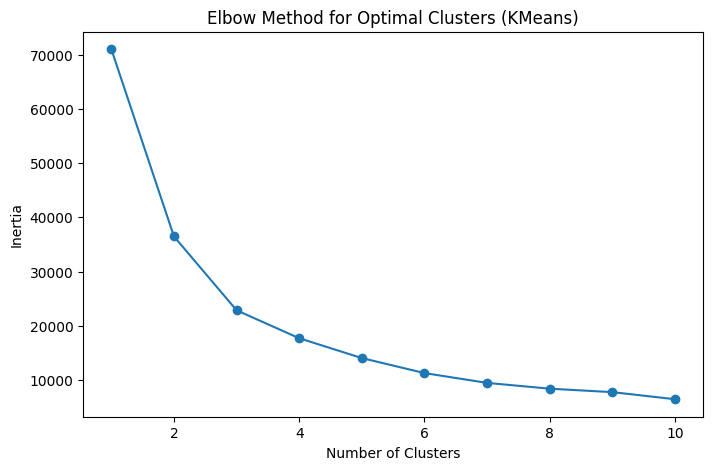

In [ ]:
# Determine optimal number of clusters using the elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters (KMeans)')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [28]:
# Fit KMeans with optimal clusters (e.g., k=3 based on elbow method)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)
data['Cluster'] = clusters

### Agglomerative Clustering (Ward)

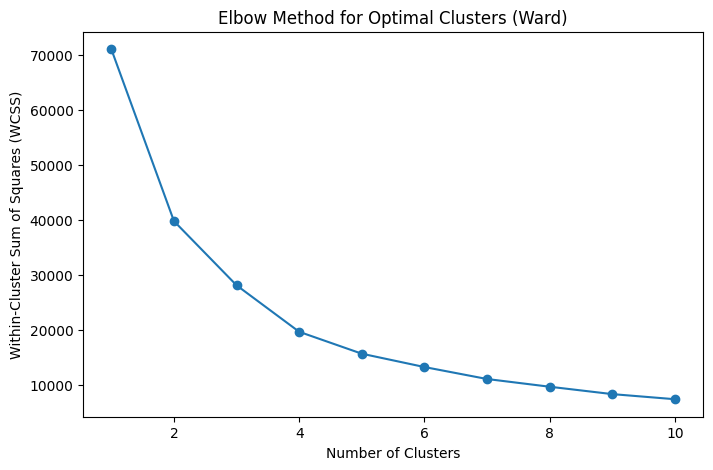

In [29]:
# Determine optimal number of clusters using the elbow method
wcss = []
k_range1 = range(1, 11)
for k in k_range1:
    ward = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = ward.fit_predict(pca_features)
    wcss.append(calculate_wcss(pca_features, labels))

plt.figure(figsize=(8, 5))
plt.plot(k_range1, wcss, marker='o')
plt.title('Elbow Method for Optimal Clusters (Ward)')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

In [30]:
clustering = AgglomerativeClustering(n_clusters=3, linkage='ward')
clusters1 = clustering.fit_predict(pca_features)
data['Ward'] = clusters1

### Self-Organizing Map (SOM) Clustering

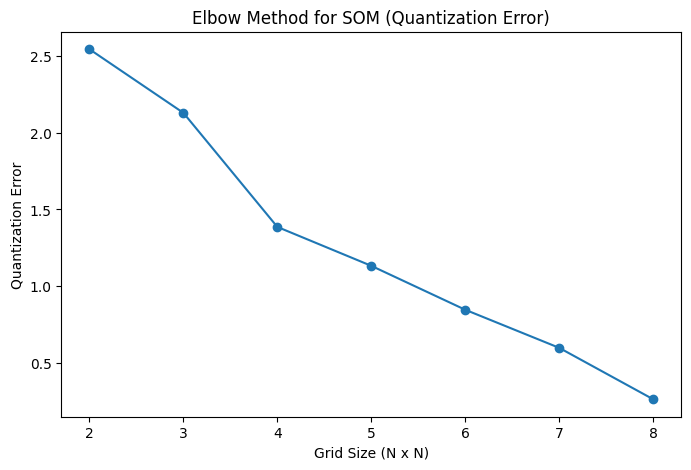

In [32]:
# Determine optimal grid size using quantization error
quantization_errors = []
grid_sizes = range(2, 9)  # Test grid sizes from 2x2 to 8x8
data_array = data[['tp', 't2m']].values  # Select relevant features and convert to NumPy array

for size in grid_sizes:
    som = MiniSom(size, size, data_array.shape[1], sigma=1.0, learning_rate=0.5)
    som.random_weights_init(data_array)
    som.train_random(data_array, 100)  # Train for 100 iterations
    quantization_errors.append(calculate_quantization_error(som, data_array))

plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, quantization_errors, marker='o')
plt.title('Elbow Method for SOM (Quantization Error)')
plt.xlabel('Grid Size (N x N)')
plt.ylabel('Quantization Error')
plt.show()

In [33]:
# Fit SOM with optimal grid size (e.g., 5x5)
som_grid_size = 5
som = MiniSom(som_grid_size, som_grid_size, data_array.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(data_array)
som.train_random(data_array, 100)
som_clusters = np.array([som.winner(x)[0] * som_grid_size + som.winner(x)[1] for x in data_array])
data['SOM_Cluster'] = som_clusters

# Visualization

### Visualize KMeans and Ward clusters on PCA-reduced dimensions

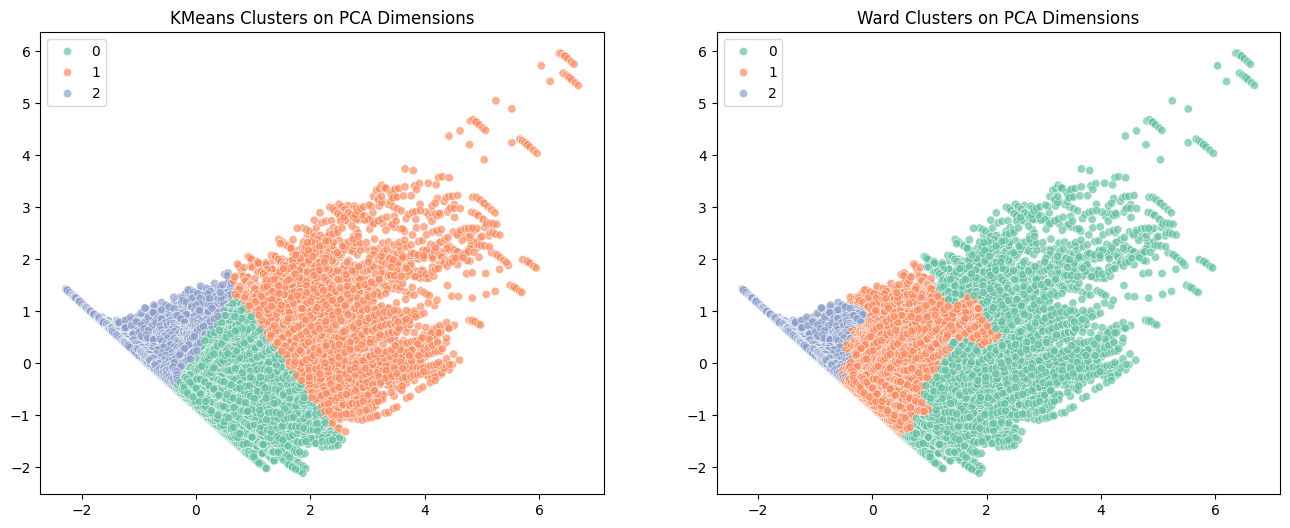

In [34]:
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=clusters, palette='Set2', alpha=0.7)
plt.title('KMeans Clusters on PCA Dimensions')

plt.subplot(1, 2, 2)
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=clusters1, palette='Set2', alpha=0.7)
plt.title('Ward Clusters on PCA Dimensions')
plt.show()


### Visualize SOM clusters on PCA-reduced dimensions

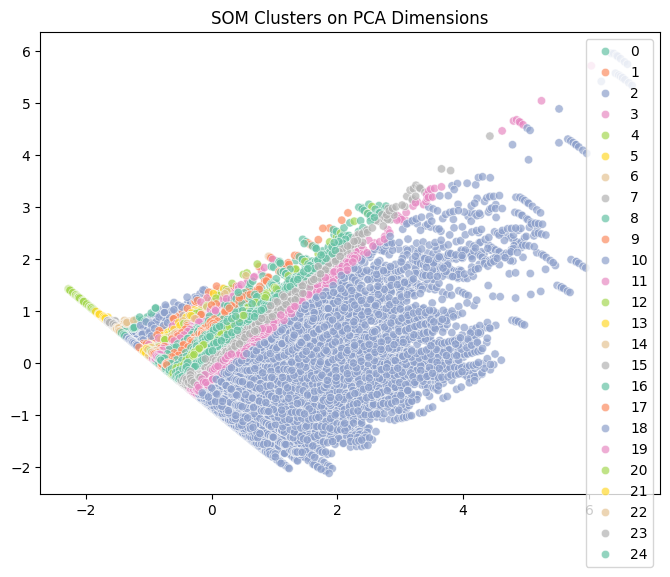

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_features[:, 0], y=pca_features[:, 1], hue=som_clusters, palette='Set2', alpha=0.7)
plt.title('SOM Clusters on PCA Dimensions')
plt.show()

# Evaluation

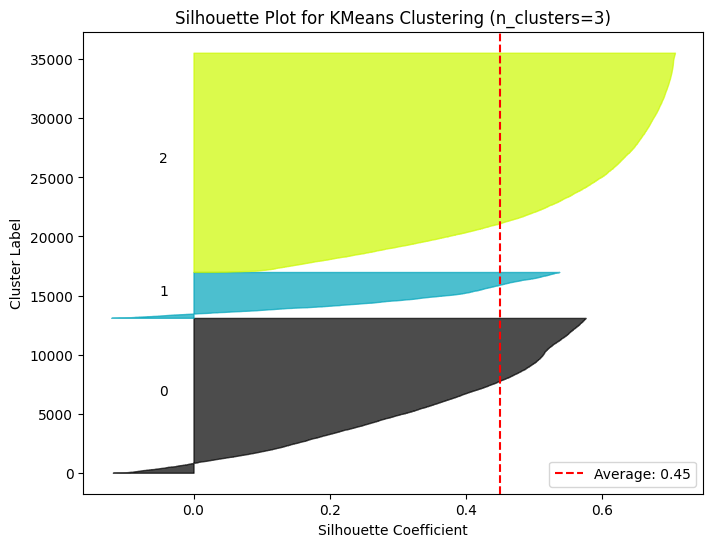

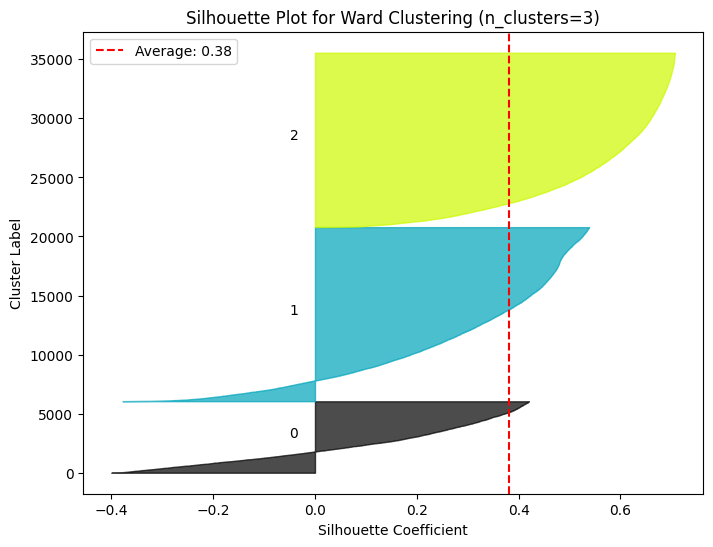

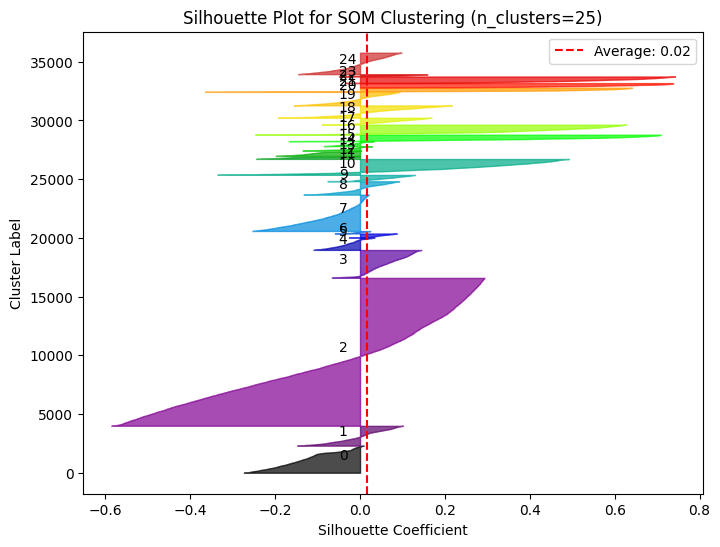

In [41]:

def plot_silhouette(X, labels, n_clusters, title):
    plt.figure(figsize=(8, 6))
    silhouette_avg = silhouette_score(X, labels)
    sample_silhouette_values = silhouette_samples(X, labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for points in the current cluster
        cluster_silhouette_values = sample_silhouette_values[labels == i]
        cluster_silhouette_values.sort()

        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10

    plt.title(f'Silhouette Plot for {title} (n_clusters={n_clusters})')
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster Label')
    plt.axvline(x=silhouette_avg, color='red', linestyle='--', label=f'Average: {silhouette_avg:.2f}')
    plt.legend()
    plt.show()

# Plot Silhouette for KMeans
plot_silhouette(pca_features, clusters, n_clusters=3, title='KMeans Clustering')

# Plot Silhouette for Ward Clustering
plot_silhouette(pca_features, clusters1, n_clusters=3, title='Ward Clustering')

# Plot Silhouette for SOM Clustering
plot_silhouette(pca_features, som_clusters, n_clusters=len(np.unique(som_clusters)), title='SOM Clustering')